In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import gtfs_kit as gk
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import pyproj
from tqdm import tqdm
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [37]:
# utilities

def calculate_distance(coord1, coord2):
    transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:31370")
    # Convert the coordinates to the Lambert 72 projection
    x1, y1 = transformer.transform(coord1[0], coord1[1])
    x2, y2 = transformer.transform(coord2[0], coord2[1])
    # Compute the distance
    dist = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    return dist

def is_within_radius(tec_stop, sncb_stops, buffer_radius):
    for index, sncb_stop in sncb_stops.iterrows():
        sncb_point = Point(sncb_stop['stop_lon'], sncb_stop['stop_lat'])
        tec_point = Point(tec_stop['stop_lon'], tec_stop['stop_lat'])
        if tec_point.distance(sncb_point) <= buffer_radius:
            return True
    return False

def extract_city_name(stop_name):
    return stop_name.split()[0]

# converting timetables hh:mm:ss in secondes
def time_convert(x):
    times = x.split(':')
    return (3600*int(times[0])+60*int(times[1]))+int(times[2])

def clean_tec(tec_df_of_day, tec_stops, day):
    tec_df_of_day = tec_df_of_day[tec_df_of_day["stop_id"].isin(tec_stops["stop_id"])]
    tec_df_of_day.drop(['stop_sequence', 'pickup_type', 'drop_off_type'], axis=1, inplace=True)
    if not tec_df_of_day.empty:
        tec_df_of_day = tec_df_of_day.merge(tec_stops[['stop_id', 'train_stop_name']], on='stop_id', how='left')
        tec_df_of_day.sort_values(by='departure_time', inplace=True)
        tec_df_of_day['departure_time_s'] = tec_df_of_day['departure_time'].apply(time_convert)
        tec_df_of_day["date"] = day
        res = tec_df_of_day
    else:
        res = pd.DataFrame()
    return res

def clean_sncb(sncb_df_of_day, sncb_stops, day):
    sncb_df_of_day = sncb_df_of_day[sncb_df_of_day["stop_id"].isin(sncb_stops["stop_id"])]
    sncb_df_of_day.drop(['stop_sequence', 'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled'], axis=1, inplace=True)
    if not sncb_df_of_day.empty:
        sncb_df_of_day = sncb_df_of_day.merge(sncb_stops[['stop_id', 'stop_name']], on='stop_id', how='left')
        sncb_df_of_day.sort_values(by='arrival_time', inplace=True)
        sncb_df_of_day['arrival_time_s'] = sncb_df_of_day['arrival_time'].apply(time_convert)
        sncb_df_of_day["date"] = day
        res = sncb_df_of_day
    else:
        res = pd.DataFrame()
    return res

### PARAMETERS

In [3]:
# paramétrage
# on maintient les points d'arrêts dont la distance est plus petite ou égale à 200 m
# time_leaving_station : on considère un temps pour sortir de la gare de 3 min (constant quelle que soit la gare)

speed_pedestrian_km = 3.5 #km/h
speed_pedestrian = speed_pedestrian_km * (1000 / 3600) #m/s
time_leaving_station = 180 # 3min

### EXPLORATION

SNCB

In [8]:
sncb_feed = gk.read_feed(r"data/sncb14nov.zip", dist_units='km')

stop_names = ["Ottignies", "Wavre", "Nivelles"]
stop_name_mapping = {
    "8811601": "OTTIGNIES",
    "8811726": "WAVRE",
    "8814209": "NIVELLES"
}
sncb_stops = sncb_feed.stops[(sncb_feed.stops["stop_name"].isin(stop_names)) & (sncb_feed.stops["stop_id"].isin(stop_name_mapping))]
sncb_stops["stop_name"] = sncb_stops["stop_name"].apply(lambda x : x.upper())
sncb_stops.drop(["stop_code"], axis=1, inplace=True)
sncb_stops

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code,stop_timezone_header
201,8811601,OTTIGNIES,NaN,50.67367,4.569360,NaN,NaN,0,S8811601,NaN,NaN
219,8811726,WAVRE,NaN,50.71627,4.604780,NaN,NaN,0,S8811726,NaN,NaN
412,8814209,NIVELLES,NaN,50.59964,4.335065,NaN,NaN,0,S8814209,NaN,NaN


In [10]:
sncb_filtered_trips = sncb_feed.stop_times[sncb_feed.stop_times["stop_id"].isin(sncb_stops["stop_id"])]
sncb_filtered_trips["stop_name"] = sncb_filtered_trips["stop_id"].map(stop_name_mapping)
sncb_filtered_trips["stop_name"] = sncb_filtered_trips["stop_name"].fillna(sncb_filtered_trips["stop_name"])
sncb_filtered_trips.drop(['stop_sequence', 'stop_headsign' ,'pickup_type', 'drop_off_type', 'shape_dist_traveled'], axis=1, inplace=True)
sncb_filtered_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_name
7141,88____:049::8811726:8833001:10:2405:20240208,23:27:00,23:27:00,8811726,WAVRE
12496,88____:049::8814001:8814209:13:912:20240113,09:12:00,09:12:00,8814209,NIVELLES
12525,88____:049::8814001:8814209:13:1012:20240113,10:12:00,10:12:00,8814209,NIVELLES
12538,88____:049::8814001:8814209:13:1112:20240113,11:12:00,11:12:00,8814209,NIVELLES
12551,88____:049::8814001:8814209:13:1212:20240113,12:12:00,12:12:00,8814209,NIVELLES


TEC

Download and rename gtfs data from TEC to "tec14nov.zip" here : https://opendata.tec-wl.be/Archive%20GTFS/GTFS20231114.zip

Move into data folder

In [15]:
tec_feed = gk.read_feed(r"data/tec14nov.zip", dist_units='km')
stop_names = ["NIVELLES", "WAVRE", "OTTIGNIES"]
tec_stops = tec_feed.stops[tec_feed.stops["stop_name"].str.contains('|'.join(stop_names))]

buffer_radius = 0.002  # 0.002 degrees is approximately 200m

tec_stops = tec_stops[tec_stops.apply(is_within_radius, args=(sncb_stops, buffer_radius,), axis=1)]
tec_stops.drop(["stop_code", "stop_desc", "stop_url", "location_type"], axis=1, inplace=True)
tec_stops['train_stop_name'] = tec_stops['stop_name'].apply(extract_city_name)
tec_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,train_stop_name
1898,Bnivga11,NIVELLES Gare - Quai 1,50.601047,4.334725,6110,NIVELLES
1899,Bnivga12,NIVELLES Gare - Quai 1,50.600940,4.334703,6110,NIVELLES
1900,Bnivga21,NIVELLES Gare - Quai 2,50.600441,4.334656,6110,NIVELLES
1901,Bnivga22,NIVELLES Gare - Quai 2,50.600155,4.334595,6110,NIVELLES
1902,Bnivga31,NIVELLES Gare - Quai 3,50.600369,4.334801,6110,NIVELLES


In [16]:
stop_names = ["NIVELLES", "WAVRE", "OTTIGNIES"]
tec_stops_general = tec_feed.stops[tec_feed.stops["stop_name"].str.contains('|'.join(stop_names))]
tec_stops_general

bus_gtfs_feed =  tec_feed
train_gtfs_feed = sncb_feed

bus_stops_gdf = gpd.GeoDataFrame(tec_stops_general, geometry=gpd.points_from_xy(tec_stops_general['stop_lon'], tec_stops_general['stop_lat']))
train_stops_gdf = gpd.GeoDataFrame(sncb_stops, geometry=gpd.points_from_xy(sncb_stops['stop_lon'], sncb_stops['stop_lat']))

combined_stops_gdf = gpd.GeoDataFrame(pd.concat([bus_stops_gdf, train_stops_gdf], ignore_index=True))

m = folium.Map(tiles="cartodbpositron", location=[combined_stops_gdf['geometry'].y.mean(), combined_stops_gdf['geometry'].x.mean()], zoom_start=12)

# satellite view

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = False,
#         control = True
#        ).add_to(m)

for _, bus_stop in bus_stops_gdf.iterrows():
    folium.Marker([bus_stop['geometry'].y, bus_stop['geometry'].x], popup=bus_stop['stop_name'], icon=folium.Icon(color='blue')).add_to(m)

# Add train stops to the map
for _, train_stop in train_stops_gdf.iterrows():
    folium.Marker([train_stop['geometry'].y, train_stop['geometry'].x], popup=train_stop['stop_name'], icon=folium.Icon(color='green')).add_to(m)
    folium.Circle([train_stop['stop_lat'], train_stop["stop_lon"]],radius=200).add_to(m)

display(m)

In [17]:
tec_filtered_trips = tec_feed.stop_times[tec_feed.stop_times["stop_id"].isin(tec_stops["stop_id"])]
tec_filtered_trips = tec_filtered_trips.merge(tec_stops[['stop_id', 'train_stop_name']], on='stop_id', how='left')
tec_filtered_trips.drop(['stop_sequence', 'pickup_type', 'drop_off_type'], axis=1, inplace=True)
tec_filtered_trips

,trip_id,arrival_time,departure_time,stop_id,train_stop_name
0,40582983-B_2023-BW_A_P2-Sem-N-3-25-1101100,16:13:00,16:13:00,Bwavgr11,WAVRE
1,40582983-B_2023-BW_A_P2-Sem-N-3-30-1101100,16:13:00,16:13:00,Bwavgr11,WAVRE
2,40582984-B_2023-BW_A_P2-Mercredi-25-0010000,13:00:00,13:00:00,Bwavgr11,WAVRE
3,40582984-B_2023-BW_A_P2-Mercredi-30-0010000,13:00:00,13:00:00,Bwavgr11,WAVRE
4,40582985-B_2023-BW_A_P2-Mercredi-25,08:15:00,08:15:00,Bwavgr11,WAVRE
...,...,...,...,...,...
16205,41091174-B_2024-BW_P_P2-Semaine-01-0010000,13:41:00,13:41:00,Bottdmv1,OTTIGNIES
16206,41091175-B_2024-BW_P_P2-Semaine-01-0010000,12:25:00,12:25:00,Bottdmv1,OTTIGNIES
16207,41091175-B_2024-BW_P_P2-Semaine-01-0010000,12:41:00,12:41:00,Bottdmv1,OTTIGNIES
16208,41091176-B_2024-BW_P_P2-Semaine-01-0010000,12:00:00,12:00:00,Bottdmv1,OTTIGNIES


### EXCEL DATA FROM SNCB

In [18]:
path = 'TR Multimodality index - Data & information/BPT42_2023_StationsLocationCoordinates/'
buildings_path = path + 'B_ST_202212_Stations_Buildings_L08.xlsx'
accesPoints_platform_path = path + 'B_PT_202212_Stations_AccesPoints_Platform_All_L08.xlsx'
accesPoints_roadNetwork_path = path + 'B_PT_202212_Stations_AccesPoints_RoadNetwork_All_ActiveModes_L08.xlsx'

xlsx_buildings = pd.read_excel(buildings_path, sheet_name='Data')
xlsx_accesPoints_platform = pd.read_excel(accesPoints_platform_path, sheet_name='Data')
xlsx_accesPoints_roadNetwork = pd.read_excel(accesPoints_roadNetwork_path, sheet_name='Data')

CENTER OF STATION BUILDINGS

In [19]:
ottignies_buildings = xlsx_buildings[xlsx_buildings["Name"] == "OTTIGNIES"]
ottignies_lat_lon = (ottignies_buildings["Lat_Y_W84"].values[0], ottignies_buildings["Lon_X_W84"].values[0])

wavre_buildings = xlsx_buildings[xlsx_buildings["Name"] == "WAVRE"]
wavre_lat_lon = (wavre_buildings["Lat_Y_W84"].values[0], wavre_buildings["Lon_X_W84"].values[0])

nivelles_buildings = xlsx_buildings[xlsx_buildings["Name"] == "NIVELLES"]
nivelles_lat_lon = (nivelles_buildings["Lat_Y_W84"].values[0], nivelles_buildings["Lon_X_W84"].values[0])

xlsx_buildings

,OBJECTID,PTCAR,UIC7_CODE,Name,Lon_X_W84,Lat_Y_W84
0,46,936,8811601,OTTIGNIES,4.569512,50.673451
1,198,1223,8811726,WAVRE,4.605485,50.716075
2,509,911,8814209,NIVELLES,4.334981,50.599862


Acces Points Platform

DESCRIPTION DES DONNÉES : Localisation des points d'accès au complexe de quais des points d’arrêts ferroviaires desservis par les trains de voyageurs opérés par la SNCB, compte tenu de l’offre du plan de transport 12/2022

ID_Orig             : Origineel uniek object ID

Name_SNCB_SARA      : Naam station

Type_origin : Type toegangspunt :
- L : Perrontoegang waarbij verbinding tussen perrontoegangen zich op niveau

- B : (Platform access where connections between platform accesses are located above the tracks)

- T : (Platform access where connections between platform accesses are located under the tracks)

PTCAR	            :	PTCAR identificatienummer van station

Num	                :	Nummering van perrontoegang

Side	            :	(Access from one or two sides of the station)

PTCAR_Num	        :	Combinatie van PTCAR en nummer toegang

Platform_ND_A	    :	(Distance via public domain between the platform access and the access to the road network accessible to active modes (in m))

Platform_Platform	:	(Distance between the first and last platform (in m))

Lon_X_WGS84	        :	Longitude du point d'accès considéré au complexe de quais de la gare considérée dans le système de coordonnées géographiques WGS84

Lat_Y_WGS84	        :	Latitude du point d'accès considéré au complexe de quais de la gare considérée dans le système de coordonnées géographiques WGS84


In [20]:
xlsx_accesPoints_platform

,OBJECTID,ID_Orig,Name_SNCB_SARA,Type_origin,PTCAR,Num,Side,PTCAR_Num,Platform_ND_A,Platform_Platform,Lon_X_WGS84,Lat_Y_WGS84
0,875,1673,NIVELLES,T,911,2,2,911 - 2,41.343055,16.155687,4.335249,50.601060
1,876,1674,NIVELLES,T,911,3,2,911 - 3,27.745876,16.155687,4.335475,50.601042
2,155,315,OTTIGNIES,T,936,1,2,936 - 1,73.136792,64.706243,4.569306,50.673759
3,156,316,OTTIGNIES,T,936,1,2,936 - 1,73.136792,64.706243,4.569651,50.673846
4,154,314,OTTIGNIES,T,936,2,2,936 - 2,NaN,64.706243,4.568799,50.673633
5,153,313,OTTIGNIES,B,936,3,2,936 - 3,38.293041,27.496968,4.569363,50.673290
6,152,312,OTTIGNIES,B,936,4,2,936 - 4,90.366336,27.496968,4.568983,50.673236
7,750,1428,WAVRE,T,1223,1,2,1223 - 1,26.436949,15.629962,4.605311,50.716178
8,817,1551,WAVRE,T,1223,1,2,1223 - 1,26.436949,15.629962,4.605134,50.716263


#### AccesPoints RoadNetwork

In [21]:
dist_nivelles_accessPoint = xlsx_accesPoints_roadNetwork[xlsx_accesPoints_roadNetwork["Name_SNCB_SARA"] == "NIVELLES"]["Platform_Platform"].mean()
dist_ottignies_accessPoint = xlsx_accesPoints_roadNetwork[xlsx_accesPoints_roadNetwork["Name_SNCB_SARA"] == "OTTIGNIES"]["Platform_Platform"].mean()
dist_wavre_accessPoint = xlsx_accesPoints_roadNetwork[xlsx_accesPoints_roadNetwork["Name_SNCB_SARA"] == "WAVRE"]["Platform_Platform"].mean()

xlsx_accesPoints_roadNetwork

,OBJECTID,ID_Orig,Name_SNCB_SARA,PTCAR,Num,Side,PTCAR_Num,Platform_ND_A,Platform_Platform,Lon_X_WGS84,Lat_Y_WGS84
0,750,1672,NIVELLES,911,2,2,911 - 2,41.343055,16.155687,4.334671,50.601112
1,653,1466,NIVELLES,911,3,2,911 - 3,27.745876,16.155687,4.335708,50.601143
2,1072,2383,OTTIGNIES,936,1,2,936 - 1,73.136792,64.706243,4.569716,50.673157
3,1071,2382,OTTIGNIES,936,3,2,936 - 3,38.293041,27.496968,4.569694,50.673149
4,144,310,OTTIGNIES,936,4,2,936 - 4,90.366336,27.496968,4.567851,50.672945
5,693,1552,WAVRE,1223,1,2,1223 - 1,26.436949,15.629962,4.605598,50.716026


In [22]:
mymap = folium.Map(location=[50.6, 4.35], zoom_start=12, tiles="cartodbpositron")

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(mymap)

colors = ['red', 'green']
dataframes = [xlsx_accesPoints_platform, xlsx_accesPoints_roadNetwork]
access_point = ["platform", "road network"]
# Add markers for access points
for i, df in enumerate(dataframes):
    marker_cluster = MarkerCluster().add_to(mymap)
    for _, row in df.iterrows():
        folium.Marker(location=[row['Lat_Y_WGS84'], row['Lon_X_WGS84']],
                      popup=row['Name_SNCB_SARA'] + "\nAccess point " + access_point[i],
                      icon=folium.Icon(color=colors[i], icon='info-sign')
                      ).add_to(marker_cluster)
# Add markers for locations
locations = [nivelles_lat_lon, ottignies_lat_lon, wavre_lat_lon]
names = ['Nivelles', 'Ottignies', 'Wavre', 'Charleroi']
for loc, name in zip(locations, names):
    folium.Marker(location=loc,
                  popup=name + " Station",
                  icon=folium.Icon(color='blue', icon='info-sign')
                  ).add_to(mymap)
# Add markers for TEC stops
for _, row in tec_stops.iterrows():
    folium.Marker(location=[row['stop_lat'], row['stop_lon']],
                  popup=row['stop_name'],
                  icon=folium.Icon(color='orange', icon='info-sign')
                  ).add_to(mymap)
                  
mymap

### AUGMENT TEC STOPS WITH THE DISTANCE TO THE CORRESPONDING TRAIN STATION

In [23]:
def calculate_distance_bus_accesspoint(row):
    tec_stop_coord = (row['stop_lat'], row['stop_lon'])
    station_coords = xlsx_accesPoints_roadNetwork[['Lat_Y_WGS84', 'Lon_X_WGS84']].values
    distances = [calculate_distance(tec_stop_coord, (lat, lon)) for lat, lon in station_coords]
    min_distance_index = np.argmin(distances)
    nearest_station = xlsx_accesPoints_roadNetwork.iloc[min_distance_index]
    return distances[min_distance_index], nearest_station['Platform_ND_A'],

tec_stops[['dist_bus_to_access_point_in_m', 'dist_access_point_to_platform_in_m']] = tec_stops.apply(calculate_distance_bus_accesspoint, axis=1, result_type='expand')
tec_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,train_stop_name,dist_bus_to_access_point_in_m,dist_access_point_to_platform_in_m
1898,Bnivga11,NIVELLES Gare - Quai 1,50.601047,4.334725,6110,NIVELLES,8.219821,41.343055
1899,Bnivga12,NIVELLES Gare - Quai 1,50.600940,4.334703,6110,NIVELLES,19.301392,41.343055
1900,Bnivga21,NIVELLES Gare - Quai 2,50.600441,4.334656,6110,NIVELLES,74.677868,41.343055
1901,Bnivga22,NIVELLES Gare - Quai 2,50.600155,4.334595,6110,NIVELLES,106.618170,41.343055
1902,Bnivga31,NIVELLES Gare - Quai 3,50.600369,4.334801,6110,NIVELLES,83.193125,41.343055


In [24]:
distances = []
dict_platform = {"NIVELLES" : dist_nivelles_accessPoint, "OTTIGNIES" : dist_ottignies_accessPoint, "WAVRE" : dist_wavre_accessPoint}

for i in tec_stops.index:
    station = tec_stops['train_stop_name'][i]
    dist = tec_stops['dist_bus_to_access_point_in_m'][i]
    dist += tec_stops['dist_access_point_to_platform_in_m'][i]
    dist += dict_platform[station]
    distances.append(dist)

tec_stops["dist_to_station_in_m"] = distances
tec_stops["time_to_station_in_s"] = (tec_stops["dist_to_station_in_m"] / speed_pedestrian).apply(np.ceil)
tec_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,zone_id,train_stop_name,dist_bus_to_access_point_in_m,dist_access_point_to_platform_in_m,dist_to_station_in_m,time_to_station_in_s
1898,Bnivga11,NIVELLES Gare - Quai 1,50.601047,4.334725,6110,NIVELLES,8.219821,41.343055,65.718563,68.0
1899,Bnivga12,NIVELLES Gare - Quai 1,50.600940,4.334703,6110,NIVELLES,19.301392,41.343055,76.800134,79.0
1900,Bnivga21,NIVELLES Gare - Quai 2,50.600441,4.334656,6110,NIVELLES,74.677868,41.343055,132.176610,136.0
1901,Bnivga22,NIVELLES Gare - Quai 2,50.600155,4.334595,6110,NIVELLES,106.618170,41.343055,164.116912,169.0
1902,Bnivga31,NIVELLES Gare - Quai 3,50.600369,4.334801,6110,NIVELLES,83.193125,41.343055,140.691867,145.0


In [27]:
mymap = folium.Map(location=[50.6, 4.35], zoom_start=12, tiles="cartodbpositron")
colors = ['red', 'green']
dataframes = [xlsx_accesPoints_platform, xlsx_accesPoints_roadNetwork]
access_point = ["platform", "road network"]

# Add markers for access points
for i, df in enumerate(dataframes):
    marker_cluster = MarkerCluster().add_to(mymap)
    for _, row in df.iterrows():
        folium.Marker(location=[row['Lat_Y_WGS84'], row['Lon_X_WGS84']],
                      popup=row['Name_SNCB_SARA'] + "\nAccess point " + access_point[i],
                      icon=folium.Icon(color=colors[i], icon='info-sign')
                      ).add_to(marker_cluster)

# Add markers for locations
locations = [nivelles_lat_lon, ottignies_lat_lon, wavre_lat_lon]
names = ['Nivelles', 'Ottignies', 'Wavre']
for loc, name in zip(locations, names):
    folium.Marker(location=loc,
                  popup=name + " Station",
                  icon=folium.Icon(color='blue', icon='info-sign')
                  ).add_to(mymap)

# Add markers for TEC stops
for _, row in tec_stops.iterrows():
    folium.Marker(location=[row['stop_lat'], row['stop_lon']],
                  popup=row['stop_name'],
                  icon=folium.Icon(color='orange', icon='info-sign')
                  ).add_to(mymap)

# Add a line from 'Bnivga11' to access point with ID_Orig == 1672
bnivga11 = tec_stops[tec_stops['stop_id'] == "Bnivga21"]
bnivga11_lat, bnivga11_lon = bnivga11.stop_lat.values[0], bnivga11.stop_lon.values[0]
road_access = xlsx_accesPoints_roadNetwork[xlsx_accesPoints_roadNetwork["ID_Orig"] == 1672]
road_access_lat, road_access_lon = road_access.Lat_Y_WGS84.values[0], road_access.Lon_X_WGS84.values[0]
platform_access = xlsx_accesPoints_platform[xlsx_accesPoints_platform["ID_Orig"] == 1673]
platform_access_lat, platform_access_lon = platform_access.Lat_Y_WGS84.values[0], platform_access.Lon_X_WGS84.values[0]
folium.PolyLine(locations=[(bnivga11_lat, bnivga11_lon), (road_access_lat, road_access_lon)], color='green').add_to(mymap)
folium.PolyLine(locations=[(road_access_lat, road_access_lon), (platform_access_lat, platform_access_lon)], color='red').add_to(mymap)

# Display the map
mymap

### FIND COMMON DATES

In [28]:
tec_dates = gk.calendar.get_dates(tec_feed)
sncb_dates = gk.calendar.get_dates(sncb_feed)
common_dates = list(set(tec_dates).intersection(sncb_dates))
common_dates.sort()
print("sncb : ", len(sncb_dates))
print("tec : ", len(tec_dates))
print("common dates : ", len(common_dates))
print("dates : ", common_dates)

sncb :  404
tec :  117
common dates :  98
dates :  ['20231107', '20231108', '20231109', '20231110', '20231111', '20231112', '20231113', '20231114', '20231115', '20231116', '20231117', '20231118', '20231119', '20231120', '20231121', '20231122', '20231123', '20231124', '20231125', '20231126', '20231127', '20231128', '20231129', '20231130', '20231201', '20231202', '20231203', '20231204', '20231205', '20231206', '20231207', '20231208', '20231209', '20231210', '20231211', '20231212', '20231213', '20231214', '20231215', '20231216', '20231217', '20231218', '20231219', '20231220', '20231221', '20231222', '20231223', '20231224', '20231225', '20231226', '20231227', '20231228', '20231229', '20231230', '20231231', '20240101', '20240102', '20240103', '20240104', '20240105', '20240106', '20240107', '20240108', '20240109', '20240110', '20240111', '20240112', '20240113', '20240114', '20240115', '20240116', '20240117', '20240118', '20240119', '20240120', '20240121', '20240122', '20240123', '20240124', 

### GTFS VIA POSTGRES VALIDATION

In [29]:
tec_query = pd.read_csv("sql_validation_data/tec_query.csv")
sncb_query = pd.read_csv("sql_validation_data/sncb_query.csv")

tec_query["date"] = tec_query["date"].apply(lambda x: x.split()[0].replace("-", "")).astype(int)
sncb_query["date"] = sncb_query["date"].apply(lambda x: x.split()[0].replace("-", "")).astype(int)

tec_query['train_stop_name'] = tec_query['stop_name'].apply(lambda x: x.split()[0])
tec_query['departure_time_s'] = tec_query['departure_time'].apply(time_convert)
tec_query = pd.merge(tec_query ,tec_stops[['stop_id', 'time_to_station_in_s', 'dist_to_station_in_m']],on='stop_id', how='left')
tec_query.rename(columns={'route_id': 'tec_route_id', 'direction_id': 'tec_direction_id'}, inplace=True)
tec_query = tec_query[['trip_id', 'arrival_time', 'departure_time', 'stop_id','train_stop_name', 'departure_time_s', 'time_to_station_in_s', 'dist_to_station_in_m', 'date', 'tec_route_id', 'tec_direction_id']]
tec_query.head(2)

,trip_id,arrival_time,departure_time,stop_id,train_stop_name,departure_time_s,time_to_station_in_s,dist_to_station_in_m,date,tec_route_id,tec_direction_id
0,40706321-B_2023-BW_P_P2-Semaine-06-0010000,13:25:00,13:25:00,Bottdmv1,OTTIGNIES,48300,193.0,186.992473,20231108,B0206-18803,0
1,40706321-B_2023-BW_P_P2-Semaine-06-0010000,13:25:00,13:25:00,Bottdmv1,OTTIGNIES,48300,193.0,186.992473,20231115,B0206-18803,0


In [30]:
sncb_query['arrival_time_s'] = sncb_query['arrival_time'].apply(time_convert)
sncb_query = sncb_query[['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_name', 'arrival_time_s', 'date',]]
sncb_query['stop_name'] = sncb_query['stop_name'].str.upper() 
sncb_query.head(3)

,trip_id,arrival_time,departure_time,stop_id,stop_name,arrival_time_s,date
0,88____:007::8814001:8200100:53:2149:20231201,19:15:00,19:17:00,8811601,OTTIGNIES,69300,20231120
1,88____:007::8814001:8200100:53:2149:20231201,19:15:00,19:17:00,8811601,OTTIGNIES,69300,20231121
2,88____:007::8814001:8200100:53:2149:20231201,19:15:00,19:17:00,8811601,OTTIGNIES,69300,20231122


In [31]:
print("tec_query shape : ", tec_query.shape)
print("sncb_query shape : ", sncb_query.shape)

tec_query shape :  (104345, 11)
sncb_query shape :  (63054, 7)


In [32]:
connections_sql = pd.merge(sncb_query, tec_query, left_on=['stop_name', 'date'], right_on=['train_stop_name', 'date'], how='inner').drop(columns=['train_stop_name'])
connections_sql['duration_s'] = connections_sql['departure_time_s'] - connections_sql ['arrival_time_s']
connections_sql['waiting_time_s'] = connections_sql['duration_s'] - (connections_sql["time_to_station_in_s"] + time_leaving_station)
filtered_connections_sql = connections_sql[(3*60 < connections_sql["waiting_time_s"]) & (connections_sql["waiting_time_s"] <= 18*60)]
filtered_connections_to_improve_sql = connections_sql[((-(2*60) < connections_sql["waiting_time_s"]) & (connections_sql["waiting_time_s"] <= 3*60 )) | 
                                              (( 18*60  < connections_sql["waiting_time_s"]) & (connections_sql["waiting_time_s"] <= 23*60 ))]

In [33]:
print("total connections sql : ", connections_sql.shape)
print("acceptable connections sql : ", filtered_connections_sql.shape)
print("connections to improve sql : ", filtered_connections_to_improve_sql.shape)

total connections sql :  (22266011, 18)
acceptable connections sql :  (325885, 18)
connections to improve sql :  (221322, 18)


In [34]:
connections_sql = 0

### CONNECTION ANALYSIS

Run next cell once : results saved in csv

Adds the date component to gtfs data (gtfs only has the time, not the date)

In [56]:
# initialisation
tec_correct_trips = gk.stop_times.get_stop_times(tec_feed, common_dates[0])
tec_correct_trips = clean_tec(tec_correct_trips, tec_stops, common_dates[0])

sncb_correct_trips = gk.stop_times.get_stop_times(sncb_feed, common_dates[0])
sncb_correct_trips = clean_sncb(sncb_correct_trips, sncb_stops, common_dates[0])

# iterate over the common dates
for i in tqdm(range(1, len(common_dates))):
    tec_df_of_day = gk.stop_times.get_stop_times(tec_feed, common_dates[i])
    tec_df_of_day = clean_tec(tec_df_of_day, tec_stops, common_dates[i])
    sncb_df_of_day = gk.stop_times.get_stop_times(sncb_feed, common_dates[i])
    sncb_df_of_day = clean_sncb(sncb_df_of_day, sncb_stops, common_dates[i])
    if len(tec_df_of_day) !=  0:
        tec_correct_trips = pd.concat([tec_correct_trips, tec_df_of_day])
    if len(sncb_df_of_day) !=  0:
        sncb_correct_trips = pd.concat([sncb_correct_trips, sncb_df_of_day])

tec_correct_trips.to_csv('data/tec_correct_trips.csv')
sncb_correct_trips.to_csv('data/sncb_correct_trips.csv')

100%|██████████| 97/97 [07:25<00:00,  4.59s/it]


In [59]:
tec_correct_trips = pd.read_csv('data/tec_correct_trips.csv', index_col=0)
sncb_correct_trips = pd.read_csv('data/sncb_correct_trips.csv', index_col=0)

print("tec trips shape : ", tec_correct_trips.shape)
print("sncb trips shape : ", sncb_correct_trips.shape)

tec trips shape :  (104345, 7)
sncb trips shape :  (63054, 7)


In [61]:
tec_correct_trips = pd.merge(tec_correct_trips ,tec_stops[['stop_id', 'time_to_station_in_s', 'dist_to_station_in_m']],on='stop_id', how='left')
tec_correct_trips = tec_correct_trips.merge(tec_feed.trips[['trip_id', 'route_id', 'direction_id']], on='trip_id', how='left')
tec_correct_trips.rename(columns={'route_id': 'tec_route_id', 'direction_id': 'tec_direction_id'}, inplace=True)

tec_correct_trips.head(3)

,trip_id,arrival_time,departure_time,stop_id,train_stop_name,departure_time_s,date,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id
0,40709293-B_2023-BW_A_P2-Sem-N-3-25,04:37:00,04:37:00,Bnivga21,NIVELLES,16620,20231107,136.0,132.176610,B0019-19693,1
1,40709293-B_2023-BW_A_P2-Sem-N-3-25,04:37:00,04:37:00,Bnivga22,NIVELLES,16620,20231107,169.0,164.116912,B0019-19693,1
2,40709325-B_2023-BW_A_P2-Sem-N-3-25,05:02:00,05:02:00,Bnivga22,NIVELLES,18120,20231107,169.0,164.116912,B0019-19693,1


In [62]:
sncb_correct_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_name,arrival_time_s,date
291,88____:078::8863008:8895208:38:633:20231208,04:45:00,04:47:00,8811601,OTTIGNIES,17100,20231107
31,88____:070::8872009:8821006:37:655:20231208,04:55:00,04:56:00,8814209,NIVELLES,17700,20231107
609,88____:078::8811601:8814001:17:613:20231208,05:16:00,05:16:00,8811601,OTTIGNIES,18960,20231107
380,88____:C70::8811601:8863115:28:718:20231208,05:22:00,05:22:00,8811601,OTTIGNIES,19320,20231107
203,88____:081::8811601:8833001:13:603:20231208,05:22:00,05:22:00,8811601,OTTIGNIES,19320,20231107


In [63]:
connections = pd.merge(sncb_correct_trips, tec_correct_trips, left_on=['stop_name', 'date'], right_on=['train_stop_name', 'date'], how='inner').drop(columns=['train_stop_name'])
connections['duration_s'] = connections['departure_time_s'] - connections ['arrival_time_s']
connections['waiting_time_s'] = connections['duration_s'] - (connections["time_to_station_in_s"] + time_leaving_station)

connections.head(2)

,trip_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_name,arrival_time_s,date,trip_id_y,arrival_time_y,departure_time_y,stop_id_y,departure_time_s,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id,duration_s,waiting_time_s
0,88____:078::8863008:8895208:38:633:20231208,04:45:00,04:47:00,8811601,OTTIGNIES,17100,20231107,40709293-B_2023-BW_A_P2-Sem-N-3-25,05:14:00,05:14:00,Bottgar7,18840,174.0,168.203835,B0019-19693,1,1740,1386.0
1,88____:078::8863008:8895208:38:633:20231208,04:45:00,04:47:00,8811601,OTTIGNIES,17100,20231107,40709259-B_2023-BW_A_P2-Sem-N-3-25,05:25:00,05:25:00,Bottgar7,19500,174.0,168.203835,B0019-19693,0,2400,2046.0


#### Acceptable connections : 
* 3 minutes < Waiting Time <= 18 minutes

In [64]:
filtered_connections = connections[(3*60 < connections["waiting_time_s"]) & (connections["waiting_time_s"] <= 18*60)]
filtered_connections.head(2)

,trip_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_name,arrival_time_s,date,trip_id_y,arrival_time_y,departure_time_y,stop_id_y,departure_time_s,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id,duration_s,waiting_time_s
393,88____:078::8811601:8814001:17:613:20231208,05:16:00,05:16:00,8811601,OTTIGNIES,18960,20231107,40709259-B_2023-BW_A_P2-Sem-N-3-25,05:25:00,05:25:00,Bottgar7,19500,174.0,168.203835,B0019-19693,0,540,186.0
394,88____:078::8811601:8814001:17:613:20231208,05:16:00,05:16:00,8811601,OTTIGNIES,18960,20231107,40709325-B_2023-BW_A_P2-Sem-N-3-25,05:39:00,05:39:00,Bottgar7,20340,174.0,168.203835,B0019-19693,1,1380,1026.0


#### Connections to improve : 
* -2 minutes < Waiting Time <= 3 minutes  
* & 18 minutes < Waiting Time <= 23 minutes

In [65]:
filtered_connections_to_improve = connections[((-(2*60) < connections["waiting_time_s"]) & (connections["waiting_time_s"] <= 3*60 )) | 
                                              (( 18*60  < connections["waiting_time_s"]) & (connections["waiting_time_s"] <= 23*60 ))]
filtered_connections_to_improve.head(2)

,trip_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_name,arrival_time_s,date,trip_id_y,arrival_time_y,departure_time_y,stop_id_y,departure_time_s,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id,duration_s,waiting_time_s
1572,88____:007::8864006:8814001:41:629:20231110,05:44:00,05:45:00,8811601,OTTIGNIES,20640,20231107,40709294-B_2023-BW_A_P2-Sem-N-3-25,06:09:00,06:09:00,Bottgar7,22140,174.0,168.203835,B0019-19693,1,1500,1146.0
1965,88____:078::8811676:8895208:29:733:20231208,05:47:00,05:48:00,8811601,OTTIGNIES,20820,20231107,40709967-B_2023-BW_A_P2-Sem-N-3-25,06:15:00,06:15:00,Bottgar6,22500,157.0,152.306195,B0039-18394,1,1680,1343.0


In [66]:
print("total connections : ", connections.shape)
print("acceptable connections : ", filtered_connections.shape)
print("connections to improve : ", filtered_connections_to_improve.shape)

total connections :  (22266011, 18)
acceptable connections :  (325885, 18)
connections to improve :  (221322, 18)


### ADJUSTING REDUNDANT BUS LINES BASED ON WAITING TIMES

In [67]:
def custom_score(waiting_time):
    # scoring function on the waiting time, can be changed
    mean = 540  # Mean of the distribution (center of the curve)
    std_dev = 180  # Standard deviation of the distribution (spread of the curve)
    score = np.exp(-((waiting_time - mean) ** 2) / (2 * std_dev ** 2))
    return score

def combine_columns(row):
    return (row['departure_time_y'], row['waiting_time_s'], row['waiting_time_score'], row.name)

def remove_best_waiting_time(row):
    combined = row['Combined']
    best_waiting_time_score = float('-inf')
    min_tuple = None
    
    for bus in combined:
        connection_score = bus[2]
        if connection_score > best_waiting_time_score:
            best_waiting_time_score = connection_score
            min_tuple = bus
    
    combined.remove(min_tuple)
    return combined

#### GROUP BY IN DETAILS

In [68]:
filtered_connections["waiting_time_score"] = filtered_connections["waiting_time_s"].apply(custom_score)
filtered_connections['Combined'] = filtered_connections.apply(combine_columns, axis=1)

train_bus_group = filtered_connections.groupby(['trip_id_x', "tec_route_id", "tec_direction_id", "date"]).agg({'Combined': lambda x: set(x)}).reset_index()
train_bus_group

,trip_id_x,tec_route_id,tec_direction_id,date,Combined
0,88____:007::8811601:8811726:4:1019:20240127,B0019-19693,1,20240127,"{(10:20:00, 246.0, 0.2634507359322567, 20269037)}"
1,88____:007::8811601:8811726:4:1019:20240127,B0020-20891,0,20240127,"{(10:23:00, 483.0, 0.9510973184771084, 2026903..."
2,88____:007::8811601:8811726:4:1019:20240127,B0020-20891,1,20240127,"{(10:33:00, 495.0, 0.9692332344763441, 20246807)}"
3,88____:007::8811601:8811726:4:1019:20240127,B0036-20894,1,20240127,"{(10:35:00, 555.0, 0.9965337989703691, 20246808)}"
4,88____:007::8811601:8811726:4:1019:20240128,B0019-19693,1,20240128,"{(10:20:00, 246.0, 0.2634507359322567, 20312369)}"
...,...,...,...,...,...
270329,88____:C70::8874609:8811726:21:1250:20231119,B0020-20891,1,20231119,"{(13:06:00, 615.0, 0.9168553557320289, 2676623)}"
270330,88____:C70::8874609:8811726:21:1250:20231119,B0543-20893,1,20231119,"{(13:06:00, 581.0, 0.9743922282183606, 2676622)}"
270331,88____:C70::8874609:8811726:21:1450:20231119,B0020-20891,0,20231119,"{(14:53:00, 684.0, 0.7261490370736909, 2670004..."
270332,88____:C70::8874609:8811726:21:1450:20231119,B0023-20892,1,20231119,"{(15:03:00, 466.0, 0.9189659827298006, 2676948)}"


In [69]:
train_bus_group = train_bus_group[train_bus_group['Combined'].apply(len) > 1]
train_bus_group

,trip_id_x,tec_route_id,tec_direction_id,date,Combined
1,88____:007::8811601:8811726:4:1019:20240127,B0020-20891,0,20240127,"{(10:23:00, 483.0, 0.9510973184771084, 2026903..."
8,88____:007::8811601:8811726:4:1119:20240127,B0020-20891,0,20240127,"{(11:23:00, 483.0, 0.9510973184771084, 2027165..."
14,88____:007::8811601:8811726:4:1219:20240127,B0020-20891,0,20240127,"{(12:23:00, 504.0, 0.9801986733067553, 2027426..."
21,88____:007::8811601:8811726:4:1319:20240127,B0020-20891,0,20240127,"{(13:23:00, 504.0, 0.9801986733067553, 2027660..."
26,88____:007::8811601:8811726:4:1419:20240127,B0020-20891,0,20240127,"{(14:23:00, 483.0, 0.9510973184771084, 2027935..."
...,...,...,...,...,...
270262,88____:C70::8874005:8811726:17:1951:20241214,B0020-20891,0,20240107,"{(19:53:00, 603.0, 0.9405880633643421, 1450045..."
270263,88____:C70::8874005:8811726:17:1951:20241214,B0020-20891,0,20240121,"{(19:53:00, 603.0, 0.9405880633643421, 1838857..."
270264,88____:C70::8874005:8811726:17:1951:20241214,B0020-20891,0,20240128,"{(19:53:00, 603.0, 0.9405880633643421, 2031996..."
270265,88____:C70::8874005:8811726:17:1951:20241214,B0020-20891,0,20240204,"{(19:53:00, 603.0, 0.9405880633643421, 2225857..."


In [70]:
train_bus_group[train_bus_group['Combined'].apply(len) > 2].iloc[0].Combined

{('06:48:00', 222.0, 0.21001936136138818, 328504),
 ('06:50:00', 233.0, 0.2335264629639829, 328506),
 ('06:50:00', 260.0, 0.29823409618142155, 328507)}

In [71]:
train_bus_group['Combined'] = train_bus_group.apply(remove_best_waiting_time, axis=1)
indexes_to_delete = [tpl[3] for combined in train_bus_group['Combined'] for tpl in combined]

print("number of redundant busses in the groupby : ", len(indexes_to_delete))
print("number of connections before redundant busses deletion : ", filtered_connections.shape[0])
print("number of connections after redundant busses deletion : ", filtered_connections.drop(index=indexes_to_delete).shape[0])

number of redundant busses in the groupby :  55551
number of connections before redundant busses deletion :  325885
number of connections after redundant busses deletion :  270334


#### GROUP BY IN A FUNCTION (same code as above without the details)

In [72]:
def delete_redundant_bus(connections, groupby):
    connections["waiting_time_score"] = connections["waiting_time_s"].apply(custom_score)  #give score to each connection
    connections['Combined'] = connections.apply(combine_columns, axis=1)

    train_bus_group = connections.groupby(groupby).agg({'Combined': lambda x: set(x)}).reset_index()
    train_bus_group = train_bus_group[train_bus_group['Combined'].apply(len) > 1]
    train_bus_group['Combined'] = train_bus_group.apply(remove_best_waiting_time, axis=1)
    indexes_to_delete = [tpl[3] for combined in train_bus_group['Combined'] for tpl in combined]
    print("number of redundant busses in the groupby : ", len(indexes_to_delete))
    print("number of connections before redundant busses deletion : ", connections.shape[0])
    connections = connections.drop(index=indexes_to_delete)
    print("number of connections after redundant busses deletion : ", connections.shape[0])
    return connections

# filtered_connections = delete_redundant_bus(filtered_connections, ['stop_id_y', 'trip_id_x', "tec_route_id", "tec_direction_id", "date"]) # with stop_id
filtered_connections = delete_redundant_bus(filtered_connections, ['trip_id_x', "tec_route_id", "tec_direction_id", "date"]) # without stop_id
filtered_connections.head(2)

number of redundant busses in the groupby :  55551
number of connections before redundant busses deletion :  325885
number of connections after redundant busses deletion :  270334


,trip_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_name,arrival_time_s,date,trip_id_y,arrival_time_y,departure_time_y,stop_id_y,departure_time_s,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id,duration_s,waiting_time_s,waiting_time_score,Combined
393,88____:078::8811601:8814001:17:613:20231208,05:16:00,05:16:00,8811601,OTTIGNIES,18960,20231107,40709259-B_2023-BW_A_P2-Sem-N-3-25,05:25:00,05:25:00,Bottgar7,19500,174.0,168.203835,B0019-19693,0,540,186.0,0.144585,"(05:25:00, 186.0, 0.1445848294171571, 393)"
394,88____:078::8811601:8814001:17:613:20231208,05:16:00,05:16:00,8811601,OTTIGNIES,18960,20231107,40709325-B_2023-BW_A_P2-Sem-N-3-25,05:39:00,05:39:00,Bottgar7,20340,174.0,168.203835,B0019-19693,1,1380,1026.0,0.026121,"(05:39:00, 1026.0, 0.026121409853918233, 394)"


In [73]:
filtered_connections_to_improve = delete_redundant_bus(filtered_connections_to_improve, ['trip_id_x', "tec_route_id", "tec_direction_id", "date"])
filtered_connections_to_improve.head(2)

number of redundant busses in the groupby :  36425
number of connections before redundant busses deletion :  221322
number of connections after redundant busses deletion :  184897


,trip_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_name,arrival_time_s,date,trip_id_y,arrival_time_y,departure_time_y,stop_id_y,departure_time_s,time_to_station_in_s,dist_to_station_in_m,tec_route_id,tec_direction_id,duration_s,waiting_time_s,waiting_time_score,Combined
1572,88____:007::8864006:8814001:41:629:20231110,05:44:00,05:45:00,8811601,OTTIGNIES,20640,20231107,40709294-B_2023-BW_A_P2-Sem-N-3-25,06:09:00,06:09:00,Bottgar7,22140,174.0,168.203835,B0019-19693,1,1500,1146.0,0.003457,"(06:09:00, 1146.0, 0.0034574559939224013, 1572)"
1965,88____:078::8811676:8895208:29:733:20231208,05:47:00,05:48:00,8811601,OTTIGNIES,20820,20231107,40709967-B_2023-BW_A_P2-Sem-N-3-25,06:15:00,06:15:00,Bottgar6,22500,157.0,152.306195,B0039-18394,1,1680,1343.0,0.000048,"(06:15:00, 1343.0, 4.7691557238153896e-05, 1965)"


### SCORING OF STATIONS BASED ON NUMBER OF CONNECTIONS

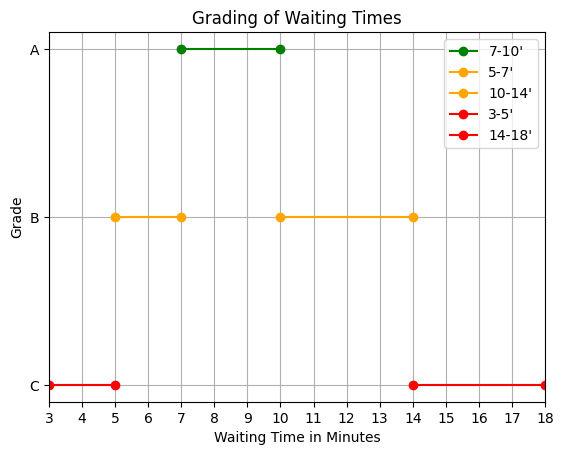

In [74]:
intervals = ['7-10\'', '5-7\'', '10-14\'', '3-5\'', '14-18\'']
grades = ['A', 'B', 'B', 'C', 'C']
interval_ranges = [(7, 10), (5, 7), (10, 14), (3, 5), (14, 18)]
colors = ['green', 'orange','orange', 'red', 'red']

for i, (interval, grade) in enumerate(zip(intervals, grades)):
    plt.plot(interval_ranges[i], [grade, grade], marker='o', label=interval, color=colors[i])

plt.xlabel('Waiting Time in Minutes')
plt.ylabel('Grade')
plt.title('Grading of Waiting Times')
plt.xlim(3, 18)  # Set x-axis limits from 3 to 18
plt.xticks(range(3, 19))  # Set x ticks from 3 to 18
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

In [75]:
minute = 60
waiting_time = filtered_connections['waiting_time_s']

conditions = [
    ((7*minute) <= waiting_time) & (waiting_time < (10*minute)),
   (((5*minute) <= waiting_time) & (waiting_time < (7*minute))) | (((10*minute) <= waiting_time) & (waiting_time < (14*minute))),
   (((3*minute) <= waiting_time) & (waiting_time < (5*minute))) | (((14*minute) <= waiting_time) & (waiting_time <= (18*minute)))
]

grades = ['A', 'B', 'C']

filtered_connections['grade'] = np.select(conditions, grades, default='X')

In [76]:
grade_counts = filtered_connections.groupby(['stop_name', 'grade']).size().reset_index(name='count')
total_counts = grade_counts.groupby('stop_name')['count'].transform('sum')
grade_counts['percentage'] = (grade_counts['count'] / total_counts) * 100
grade_counts

,stop_name,grade,count,percentage
0,NIVELLES,A,15000,18.892639
1,NIVELLES,B,30282,38.140460
2,NIVELLES,C,34114,42.966900
3,OTTIGNIES,A,33039,24.627850
4,OTTIGNIES,B,55635,41.471305
5,OTTIGNIES,C,45479,33.900845
6,WAVRE,A,12786,22.516510
7,WAVRE,B,23572,41.510962
8,WAVRE,C,20427,35.972528


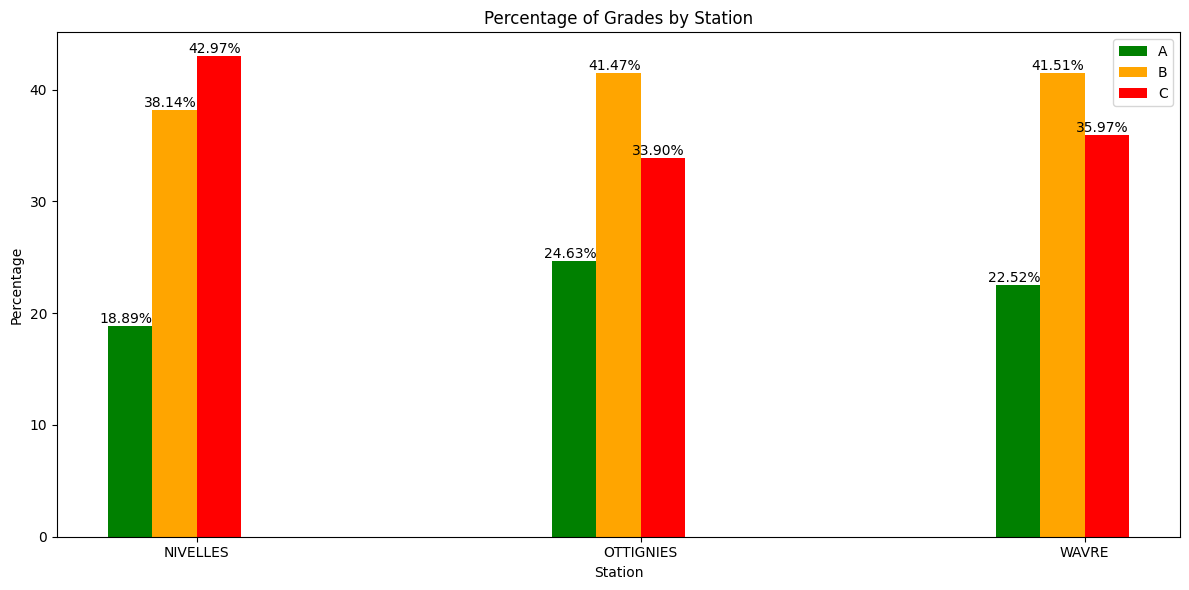

In [77]:
colors = {'A': 'green', 'B': 'orange', 'C': 'red'}
plt.figure(figsize=(12, 6))

bar_width = 0.1 
stop_names = grade_counts['stop_name'].unique()
num_stops = len(stop_names)
index = np.arange(num_stops)

# Adjust x-ticks to center them with each group of bars
plt.xticks(index + (len(colors) / 2) * bar_width, stop_names)

for i, grade in enumerate(colors):
    grade_data = grade_counts[grade_counts['grade'] == grade]
    plt.bar(index + i * bar_width, grade_data['percentage'], color=colors[grade], width=bar_width, label=grade)
    for j, percent in enumerate(grade_data['percentage']):
        plt.text(index[j] + (i + 0.5) * bar_width, percent, f'{percent:.2f}%', ha='right', va='bottom', color='black')

plt.xlabel('Station')
plt.ylabel('Percentage')
plt.title('Percentage of Grades by Station')
plt.legend()
plt.tight_layout()
plt.show()


In [78]:
print(filtered_connections.shape)
print(filtered_connections_to_improve.shape)

(270334, 21)
(184897, 20)


In [79]:
score_acceptable = filtered_connections.groupby(['stop_name']).size().reset_index(name='count_acceptable') #316k
score_improve = filtered_connections_to_improve.groupby(['stop_name']).size().reset_index(name='count_improve') #221k

In [80]:
scores = pd.merge(score_acceptable, score_improve, on='stop_name')
scores['total_count'] = scores['count_acceptable'] + scores['count_improve']
scores['percentage_acceptable'] = (scores['count_acceptable'] / scores['total_count']) * 100
scores['percentage_improve'] = (scores['count_improve'] / scores['total_count']) * 100
scores

,stop_name,count_acceptable,count_improve,total_count,percentage_acceptable,percentage_improve
0,NIVELLES,79396,56702,136098,58.337375,41.662625
1,OTTIGNIES,134153,86168,220321,60.889793,39.110207
2,WAVRE,56785,42027,98812,57.467716,42.532284


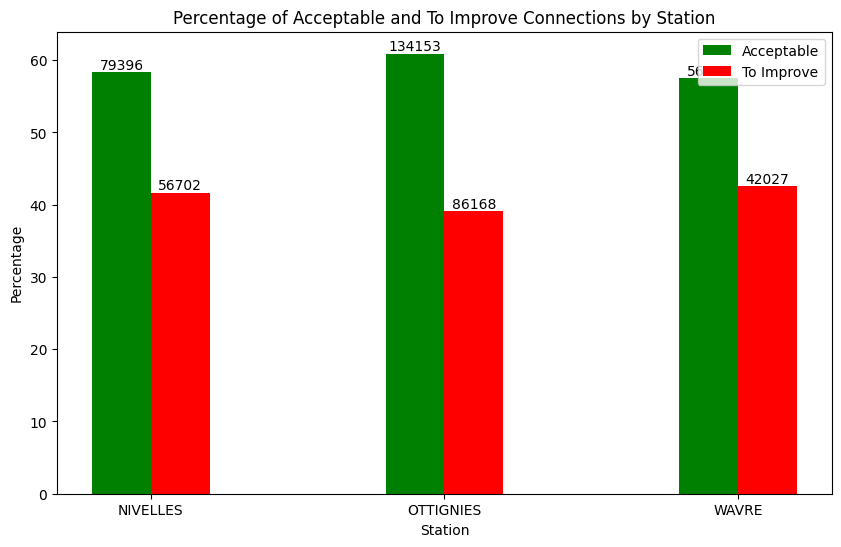

In [81]:
bar_width = 0.2

r1 = np.arange(len(scores))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))

bars1 = plt.bar(r1, scores['percentage_acceptable'], color='green', width=bar_width, label='Acceptable')
bars2 = plt.bar(r2, scores['percentage_improve'], color='red', width=bar_width, label='To Improve')

for i, bars in enumerate([bars1, bars2]):
    for j, bar in enumerate(bars):
        height = bar.get_height()
        count = scores.iloc[j, i + 1]  # Get the count value
        plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % count, ha='center', va='bottom')

plt.xlabel('Station')
plt.ylabel('Percentage')
plt.title('Percentage of Acceptable and To Improve Connections by Station')
plt.xticks([r + bar_width/2 for r in range(len(scores))], scores['stop_name'])

plt.legend()
plt.show()

### Average distances from platform to bus

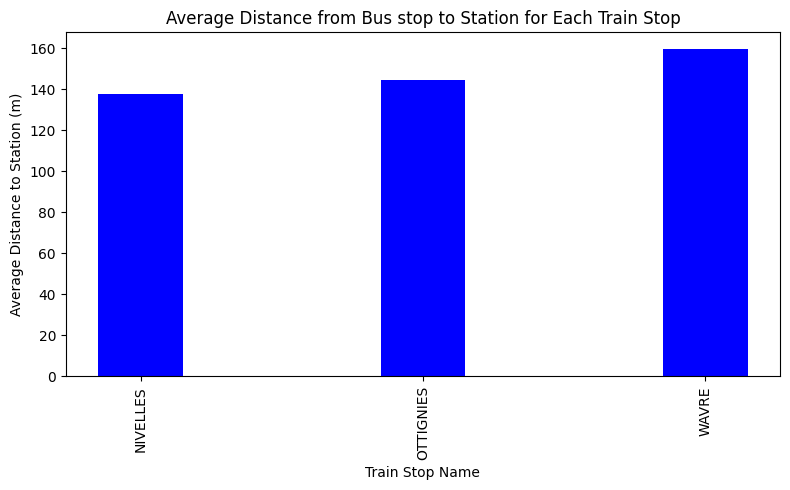

In [82]:
avg_dist_per_station = tec_stops.groupby('train_stop_name')['dist_to_station_in_m'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(avg_dist_per_station['train_stop_name'], avg_dist_per_station['dist_to_station_in_m'], color='blue', width=0.3) # Adjust the width here
plt.xlabel('Train Stop Name')
plt.ylabel('Average Distance to Station (m)')
plt.title('Average Distance from Bus stop to Station for Each Train Stop')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

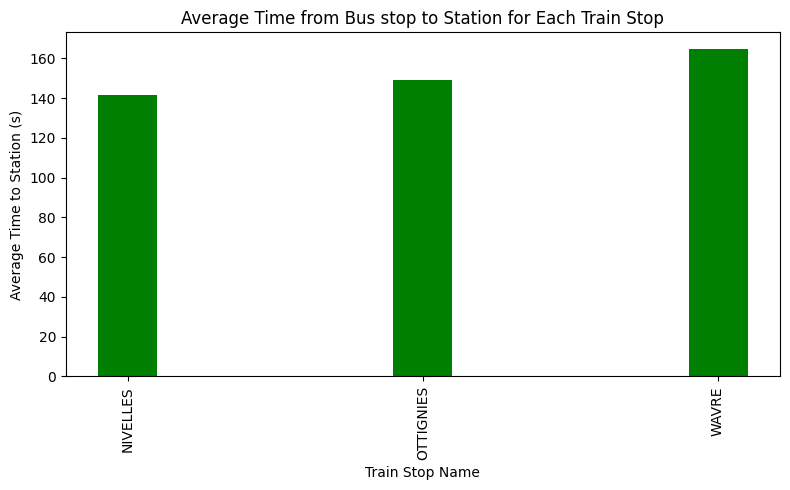

In [83]:
avg_time_per_station = tec_stops.groupby('train_stop_name')['time_to_station_in_s'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(avg_time_per_station['train_stop_name'], avg_time_per_station['time_to_station_in_s'], color='green', width=0.2)
plt.xlabel('Train Stop Name')
plt.ylabel('Average Time to Station (s)')
plt.title('Average Time from Bus stop to Station for Each Train Stop')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

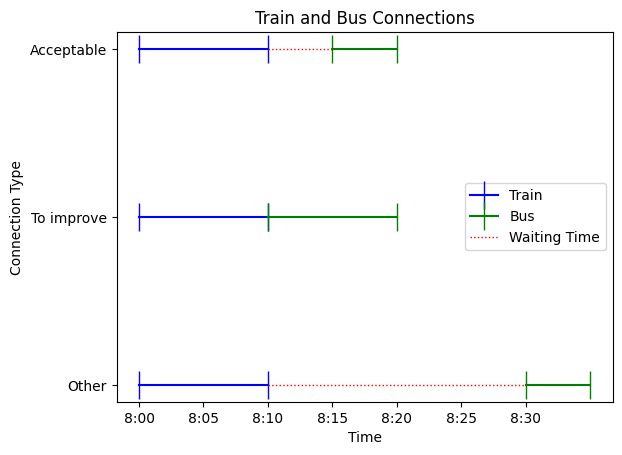

In [84]:
times = ['8:00', '8:05', '8:10', '8:15', '8:20', '8:25', '8:30']
x = np.arange(len(times))  # the label locations
train_data = [(0, 2), (0, 2), (0, 2)]
bus_data = [(3, 4), (2, 4), (6, 7)]

fig, ax = plt.subplots()

for i, data in enumerate(train_data):
    ax.plot(data, [i] * len(data), color='blue', marker='|', markersize=20, label='Train' if i == 0 else '')

for i, data in enumerate(bus_data):
    ax.plot(data, [i] * len(data), color='green', marker='|', markersize=20, label='Bus' if i == 0 else '')
    ax.plot([train_data[i][1], data[0]], [i, i], color='red', linestyle=':', linewidth=1, label='Waiting Time' if i == 0 else '')

ax.set_xlabel('Time')
ax.set_ylabel('Connection Type')
ax.set_title('Train and Bus Connections')
ax.set_yticks(np.arange(3))
ax.set_yticklabels(['Acceptable', 'To improve', 'Other'])
ax.set_xticks(x)
ax.set_xticklabels(times)
ax.invert_yaxis()
ax.legend(loc='center right')

plt.show()

### Number of bus routes passing by the stops near the stations

In [85]:
filtered_connections.groupby(["stop_name"])['tec_route_id'].nunique().reset_index()

,stop_name,tec_route_id
0,NIVELLES,21
1,OTTIGNIES,14
2,WAVRE,14


In [86]:
connections.groupby(["stop_name"])['tec_route_id'].nunique().reset_index()

,stop_name,tec_route_id
0,NIVELLES,21
1,OTTIGNIES,14
2,WAVRE,14


In [87]:
tec_temp = tec_feed.stop_times[tec_feed.stop_times["stop_id"].isin(tec_stops["stop_id"])]
tec_temp = tec_temp.merge(tec_stops[['stop_id', 'train_stop_name']], on='stop_id', how='left')
tec_temp = tec_temp.merge(tec_feed.trips[['trip_id', 'route_id', 'direction_id']], on='trip_id', how='left')
tec_temp.groupby(["train_stop_name", "stop_id"])[['route_id']].nunique()

route_id
train_stop_name stop_id           
NIVELLES        Bnivga11         5
                Bnivga12         4
                Bnivga21         2
                Bnivga22         2
                Bnivga31         5
                Bnivga32         5
                Bnivga41         1
                Bnivga51         4
                Bnivga61         4
                Bnivga72         1
                Bnivga81         1
                Bnivrwi1         5
                Bnivrwi2         3
OTTIGNIES       Bottdmv1         1
                Bottgar1         2
                Bottgar2         2
                Bottgar3         2
                Bottgar4         2
                Bottgar5         2
                Bottgar6         1
                Bottgar7         1
                Bottgar8         2
WAVRE           Bwavgr01         2
                Bwavgr02         2
                Bwavgr03         1
                Bwavgr04         2
                Bwavgr05         1
                Bwavgr06         2
                Bwavgr07         2
                Bwavgr10         3
                Bwavgr11         2
                Bwavgr12         1
                Bwavgr13         2

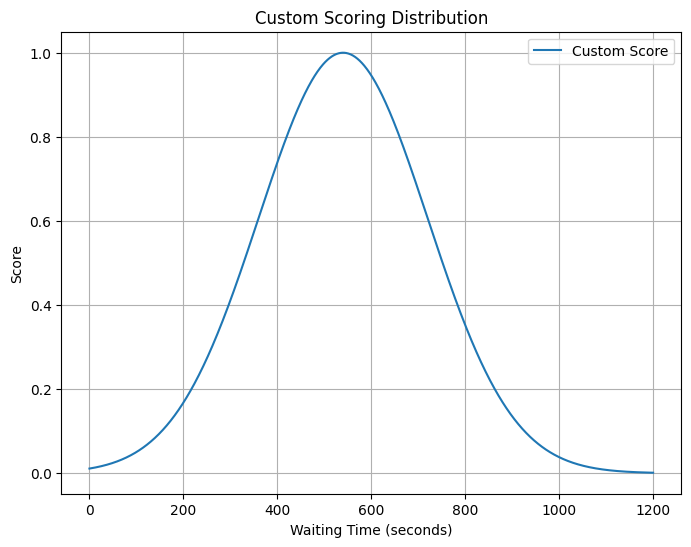

In [88]:
def custom_score(waiting_time):
    mean = 540  # Mean of the distribution (center of the curve)
    std_dev = 180  # Standard deviation of the distribution (spread of the curve)
    score = np.exp(-((waiting_time - mean) ** 2) / (2 * std_dev ** 2))
    return score

waiting_times = np.linspace(0, 1200, 1000)
scores = custom_score(waiting_times)

plt.figure(figsize=(8, 6))
plt.plot(waiting_times, scores, label='Custom Score')
plt.title('Custom Scoring Distribution')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()

In [91]:
# example of usage of scoring (parameter in seconds)
custom_score(300)

0.41111229050718745

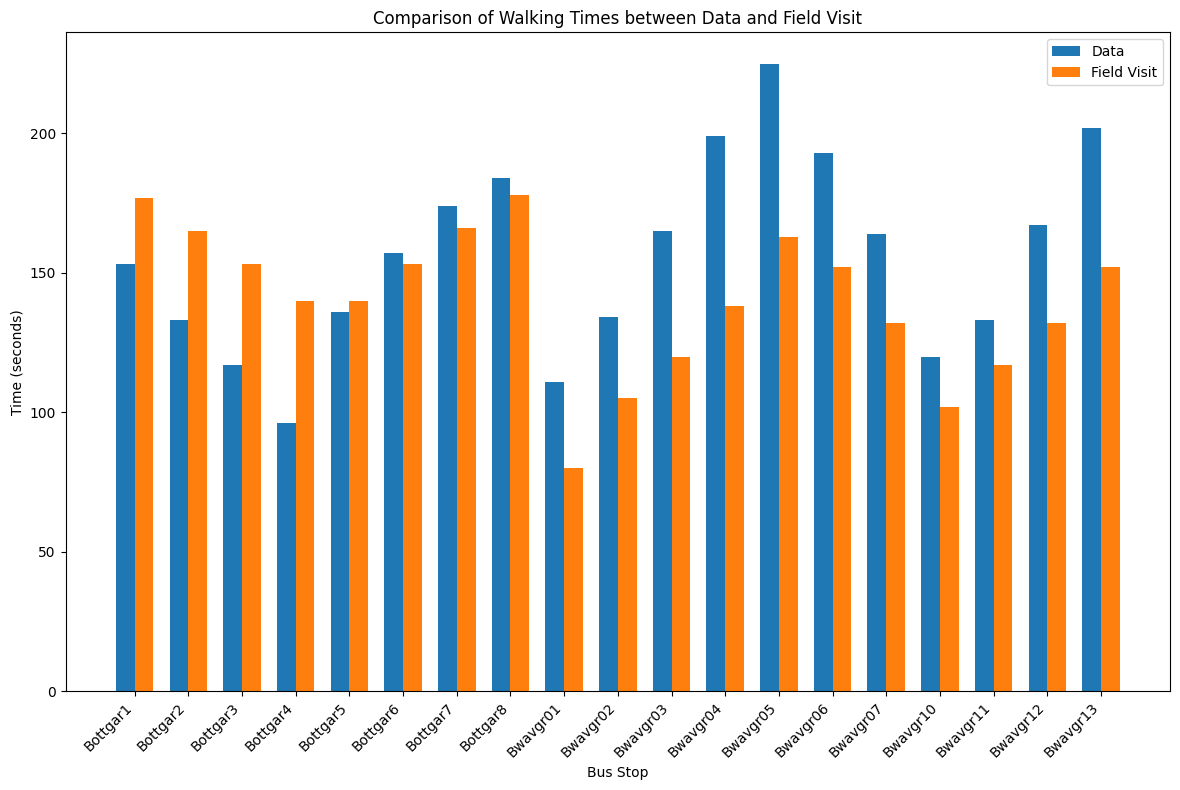

In [92]:
# Data from the table
locations = ['Bottgar1', 'Bottgar2', 'Bottgar3', 'Bottgar4', 'Bottgar5', 'Bottgar6', 'Bottgar7', 'Bottgar8', 'Bwavgr01', 'Bwavgr02', 'Bwavgr03', 'Bwavgr04', 'Bwavgr05', 'Bwavgr06', 'Bwavgr07', 'Bwavgr10', 'Bwavgr11', 'Bwavgr12', 'Bwavgr13']
data_seconds = [153, 133, 117, 96, 136, 157, 174, 184, 111, 134, 165, 199, 225, 193, 164, 120, 133, 167, 202]
field_visit_seconds = [177, 165, 153, 140, 140, 153, 166, 178, 80, 105, 120, 138, 163, 152, 132, 102, 117, 132, 152]
absolute_difference = [24, 32, 36, 44, 4, 4, 8, 6, 31, 29, 45, 61, 62, 41, 32, 18, 16, 35, 50]

x = np.arange(len(locations))

fig, ax1 = plt.subplots(figsize=(14, 8))

bar_width = 0.35
bars1 = ax1.bar(x - bar_width/2, data_seconds, bar_width, label='Data')
bars2 = ax1.bar(x + bar_width/2, field_visit_seconds, bar_width, label='Field Visit')

ax1.set_xlabel('Bus Stop')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Comparison of Walking Times between Data and Field Visit')
ax1.set_xticks(x)
ax1.set_xticklabels(locations, rotation=45, ha='right')

bars = bars1 + bars2
bar_labels = [bar.get_label() for bar in bars]
ax1.legend()

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

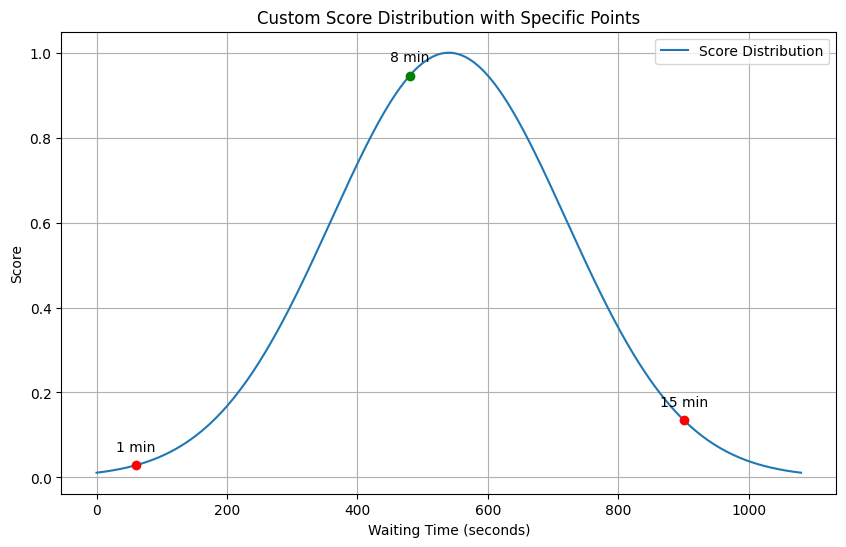

In [93]:
def custom_score(waiting_time):
    mean = 540  # Mean of the distribution (center of the curve)
    std_dev = 180  # Standard deviation of the distribution (spread of the curve)
    score = np.exp(-((waiting_time - mean) ** 2) / (2 * std_dev ** 2))
    return score

waiting_times = np.arange(0, 1081, 1)
scores = custom_score(waiting_times)

# Specific points to plot
specific_times = [1, 8, 15]
specific_scores = [custom_score(time * 60) for time in specific_times]  # Convert minutes to seconds

# Convert minutes to seconds for specific points
specific_times_seconds = [time * 60 for time in specific_times]

colors = ['red', 'green', 'red']

plt.figure(figsize=(10, 6))
plt.plot(waiting_times, scores, label='Score Distribution')
for i in range(len(specific_times)):
    plt.scatter(specific_times_seconds[i], specific_scores[i], color=colors[i], zorder=5)
    plt.annotate(f'{specific_times[i]} min', (specific_times_seconds[i], specific_scores[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Score')
plt.title('Custom Score Distribution with Specific Points')
plt.legend()

plt.grid(True)
plt.show()